## 2- Training a SGS model

In this second notebook, we show how to train a model from the dataset using PyTorch. Evaluation is postponed to the last notebook where we will look at some metrics and other physical quantities of interest. 

In [1]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

sys.path.append('../src')

from dataset import *
from train import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



### Importing training and validation data

We use the same data separation as in the paper, i.e. we take the 60 first samples from the training set as training data and the remaining 20 samples as validation data.

In [3]:
data_path = '../data/subgrid-scalar-dataset/'

train_dataset = SubgridDataset(
    device=device,
    path=data_path + 'train/08/',
    samples=100,
    established=40,
    size=64,
    x=['velocity_field_x_nd_08', 'velocity_field_y_nd_08', 'velocity_field_z_nd_08', 'scalar_field_nd_08'],
    y=['sgs_flux_div_dns_nd_08']
)

valid_dataset = SubgridDataset(
    device=device,
    path=data_path + 'train/08/', 
    samples=120,
    established=100,
    size=64,
    x=['velocity_field_x_nd_08', 'velocity_field_y_nd_08', 'velocity_field_z_nd_08', 'scalar_field_nd_08'],
    y=['sgs_flux_div_dns_nd_08']
)

### 1st model: CNN

We first create a simple CNN from the building blocks given the ``blocks`` directory. The naming are consistant with the formulation in paper:

* Non-linear convolutions units are called "ConvUnit"
* Last convolutions with 1x1x1 kernel is called "UnitaryUnit"

In [4]:
from blocks.CNN import ConvUnit, UnitaryUnit, BlockCNN

layers=[
    ConvUnit(in_size= 4, out_size=  8, kernel=3), 
    ConvUnit(in_size= 8, out_size= 16, kernel=3), 
    ConvUnit(in_size=16, out_size= 32, kernel=3), 
    ConvUnit(in_size=32, out_size= 64, kernel=3), 
    ConvUnit(in_size=64, out_size=128, kernel=3), 
    UnitaryUnit(in_size=128)
]

# create the model
CNN = BlockCNN(name='testing_CNN', layers=layers).to(device)

### Learning the model

Here we show a very simple way to learn the model for testing purposes. Obviously, ``CNN`` is a PyTorch module, and custom functions to load, train, etc can be applied.
The following code trains 100 epoch of the CNN on the labels, which in our case correspond to the divergence of the SGS flux.

Finished training, with last progress = -0.0032247602939605713


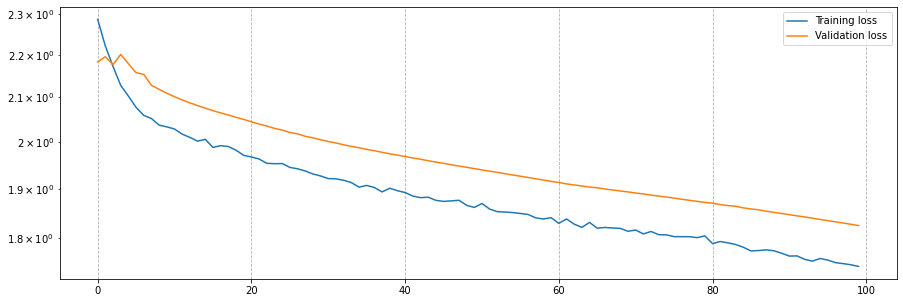

In [5]:
# create loaders for batch training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

# use an Adam optimized
opti = torch.optim.Adam(CNN.parameters(), lr=1e-4)
# adaptive learning rate can help
rate = torch.optim.lr_scheduler.StepLR(opti, step_size=250, gamma=0.75)

loop(
    net=CNN,
    model_path='../data/models',
    train_loader=train_loader,
    valid_loader=valid_loader,
    opti=opti,
    rate=rate,
    epochs=100
)